In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

csv_file = "single_thread_thp.alex_oob.csv"

# read data and group by key_path, index_type, init_table_size, test_suite
df = pd.read_csv(csv_file)

# group by as key_path index_type init_table_size test_suite
df_grouped = df.groupby(["key_path", "index_type", "init_table_size", "test_suite"])

# construct a new dataframe for each group
transformed_df = pd.DataFrame(
    columns=[
        "key_path",
        "index_type",
        "init_table_size",
        "test_suite",
        "insert_throughput_avg",
        "insert_throughput_min",
        "insert_throughput_max",
        "insert_throughput_stdv",
        "insert_throughput_cv",
        "read_throughput_avg",
        "read_throughput_min",
        "read_throughput_max",
        "read_throughput_stdv",
        "read_throughput_cv",
        "memory_consumption",
    ]
)

for name, group in df_grouped:
    key_path, index_type, init_table_size, test_suite = name
    insert_throughput_avg = group.loc[group["insert_ratio"] == 1, "throughput"].mean()
    insert_throughput_min = group.loc[group["insert_ratio"] == 1, "throughput"].min()
    insert_throughput_max = group.loc[group["insert_ratio"] == 1, "throughput"].max()
    insert_throughput_stdv = group.loc[group["insert_ratio"] == 1, "throughput"].std()
    insert_throughput_cv = insert_throughput_stdv / insert_throughput_avg
    read_throughput_avg = group.loc[group["insert_ratio"] == 0, "throughput"].mean()
    read_throughput_min = group.loc[group["insert_ratio"] == 0, "throughput"].min()
    read_throughput_max = group.loc[group["insert_ratio"] == 0, "throughput"].max()
    read_throughput_stdv = group.loc[group["insert_ratio"] == 0, "throughput"].std()
    read_throughput_cv = read_throughput_stdv / read_throughput_avg
    memory_consumption = group["memory_consumption"].mean()
    transformed_df.loc[len(transformed_df)] = [
        key_path,
        index_type,
        init_table_size,
        test_suite,
        insert_throughput_avg,
        insert_throughput_min,
        insert_throughput_max,
        insert_throughput_stdv,
        insert_throughput_cv,
        read_throughput_avg,
        read_throughput_min,
        read_throughput_max,
        read_throughput_stdv,
        read_throughput_cv,
        memory_consumption,
    ]

csv_file="single_thread_thp.csv"
df = pd.read_csv(csv_file)
df_grouped = df.groupby(["key_path", "index_type", "init_table_size", "test_suite"])

transformed_df["original_read_throughput_avg"] = np.nan
transformed_df["read_throughput_avg_change_ratio"] = np.nan
for index, row in transformed_df.iterrows():
    key_path = row["key_path"]
    index_type = row["index_type"]
    init_table_size = row["init_table_size"]
    test_suite = row["test_suite"]
    original_case_group= df_grouped.get_group((key_path, index_type, init_table_size, test_suite))
    original_read_throughput_avg = original_case_group.loc[original_case_group["insert_ratio"] == 0, "throughput"].mean()
    read_throughput_avg_change_ratio = (row["read_throughput_avg"] - original_read_throughput_avg) / original_read_throughput_avg
    transformed_df.loc[index, "original_read_throughput_avg"] = original_read_throughput_avg
    transformed_df.loc[index, "read_throughput_avg_change_ratio"] = read_throughput_avg_change_ratio

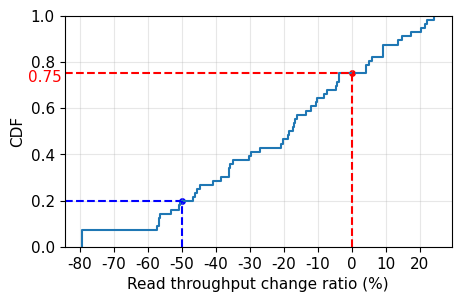

In [11]:
import matplotlib.ticker as mticker

# 过滤数据
filtered_df = transformed_df[(transformed_df["index_type"] == "alex")
                             &(transformed_df["test_suite"].isin([41,42]))]

# 绘制 CDF 图
plt.rcParams.update({"font.size": 11})
fig = plt.figure(figsize=(5,3))
sns.ecdfplot(data=filtered_df, x="read_throughput_avg_change_ratio")
# 计算 x=0 对应的 y 值
y_value_at_0 = (filtered_df["read_throughput_avg_change_ratio"] <= 0).mean()
# 计算 x=0.5 对应的 y 值
y_value_at_0_5 = (filtered_df["read_throughput_avg_change_ratio"] <= -0.5).mean()

# 添加部分虚线
plt.plot([0, 0], [0, y_value_at_0], 'r--')  # 垂直虚线
plt.axhline(y=y_value_at_0, xmin=0, xmax=0.75, color='r', linestyle='--')  # 水平虚线
plt.plot([-0.5, -0.5], [0, y_value_at_0_5], 'b--')  # 垂直虚线
plt.axhline(y=y_value_at_0_5, xmin=0, xmax=0.3, color='b', linestyle='--')  # 水平虚线

# 在 y 轴上标记 y_value
plt.text(-0.95, y_value_at_0-0.015, f'{y_value_at_0:.2f}', color='r', va='center')
# 在 x 轴上标记 -0.5
# plt.text(-0.5, 0, '-50', color='b', ha='left')
# 标记 x=0 对应的 y 值
plt.scatter(0, y_value_at_0, color='r', s=15)
# 标记 x=-0.5 对应的 y 值
plt.scatter(-0.5, y_value_at_0_5, color='b', s=15)

# 添加网格
plt.grid(True, alpha=0.3)

# 设置 x 轴为百分比格式
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{100*y:.0f}'))
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(0.2))
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(0.1))

plt.xlabel("Read throughput change ratio (%)")
plt.ylabel("CDF")
# plt.tight_layout()
# plt.show()
plt.savefig("./fig/alex_read_throughput_change_ratio_under_oob.pdf",bbox_inches="tight", transparent=True)